In [1]:
from atproto import Client
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
client = Client()
client.login(os.environ["BSKY_USER"], os.environ["BSKY_PASS"])

ProfileViewDetailed(did='did:plc:kjobm2h2kyddai6jzkvoisnn', handle='en-test.bsky.social', associated=ProfileAssociated(chat=None, feedgens=0, labeler=False, lists=0, starter_packs=0, py_type='app.bsky.actor.defs#profileAssociated', activitySubscription={'allowSubscriptions': 'followers'}), avatar='https://cdn.bsky.app/img/avatar/plain/did:plc:kjobm2h2kyddai6jzkvoisnn/bafkreido6yr2zsmc453j7ns2cs4nylvdiye5w6nb36xdmk2wwunsiiw4n4@jpeg', banner=None, created_at='2025-02-09T21:26:34.645Z', description=None, display_name='', followers_count=2, follows_count=2, indexed_at='2025-02-09T21:26:34.645Z', joined_via_starter_pack=None, labels=[], pinned_post=None, posts_count=1, verification=None, viewer=ViewerState(blocked_by=False, blocking=None, blocking_by_list=None, followed_by=None, following=None, known_followers=None, muted=False, muted_by_list=None, py_type='app.bsky.actor.defs#viewerState'), py_type='app.bsky.actor.defs#profileViewDetailed')

In [3]:
def fetch_bsky_posts(query, limit=100):
    posts = []

    response = client.app.bsky.feed.search_posts({"q": query, "limit": limit})
    for post in response.posts:
        text = post.record.text.lower()

        posts.append(
            {
                "text": text,
                "author": post.author.handle,
                "created_at": post.record.created_at,
            }
        )
    return pd.DataFrame(posts)

In [4]:
ny_posts = fetch_bsky_posts("New York OR NYC", limit=20)
ny_posts

,text,author,created_at
0,ceramic new york city subway tiles with sturdy...,ruhl.nyc,2025-07-11T19:33:22.703Z
1,% of u.s. adults who say nyc is overall the be...,today.yougov.com,2025-07-11T19:19:22.266Z
2,the best live music choices for this weekend i...,ny-news.bsky.social,2025-07-11T18:42:15+00:00
3,"bagel-blessed works too! my apologies, feel li...",dael.bsky.social,2025-07-11T18:35:22.412Z
4,191+ best prime day deals still available befo...,ny-news.bsky.social,2025-07-11T16:21:11+00:00
5,"""new york people get behind new york people. t...",alecchamilton.bsky.social,2025-07-11T12:02:30.530Z
6,uptown e f trains are ending at forest hills-7...,mtaupdates.stefanbohacek.online.ap.brid.gy,2025-07-11T10:49:17.000Z
7,shopping in times square (or who's in charge h...,majorpaincake.bsky.social,2025-07-11T03:31:33.248Z
8,alright with the new york cosmos back again; i...,cevichereign.bsky.social,2025-07-11T02:18:15.088Z
9,did the math and found i’m spending 10% of my ...,north0fnorth.tgirl.gay,2025-07-10T17:33:36.548Z


In [5]:
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # -1 (negative) to +1 (positive)

def categorize_sentiment(score):
    if score > 0.1:
        return "Positive"
    elif score < -0.1:
        return "Negative"
    else:
        return "Neutral"

def get_sentiment(df_sentiment):
    df_sentiment["sentiment"] = df_sentiment["text"].apply(analyze_sentiment)
    df_sentiment["sentiment_label"] = df_sentiment["sentiment"].apply(categorize_sentiment)
    return df_sentiment


In [6]:
def plot_sentiment(df_sentiment: pd.DataFrame, subject: str, style: str = 'seaborn-v0_8'):
    """
    Generates a bar plot to visualize the distribution of sentiment labels.

    Args:
        df_sentiment (pd.DataFrame): DataFrame containing a 'sentiment_label' column.
        subject (str): The subject of the sentiment analysis, used in the plot title.
    """
    with plt.style.context(style):
        plt.figure(figsize=(10, 6))

        sentiment_colors = {
            "Positive": "mediumseagreen",
            "Neutral": "lightslategray",
            "Negative": "tomato"
        }

        sentiment_order = ["Positive", "Neutral", "Negative"]

        sns.countplot(
            data=df_sentiment,
            x="sentiment_label",
            hue="sentiment_label",
            order=sentiment_order,
            palette=sentiment_colors
        )

        plt.title(f"Public Sentiment on {subject} (Bluesky)", fontsize=16)
        plt.xlabel("Sentiment", fontsize=12)
        plt.ylabel("Number of Posts", fontsize=12)
        plt.xticks(rotation=0) 
        plt.grid(axis='y', linestyle='--', alpha=0.7) 
        plt.tight_layout() 
        plt.show()


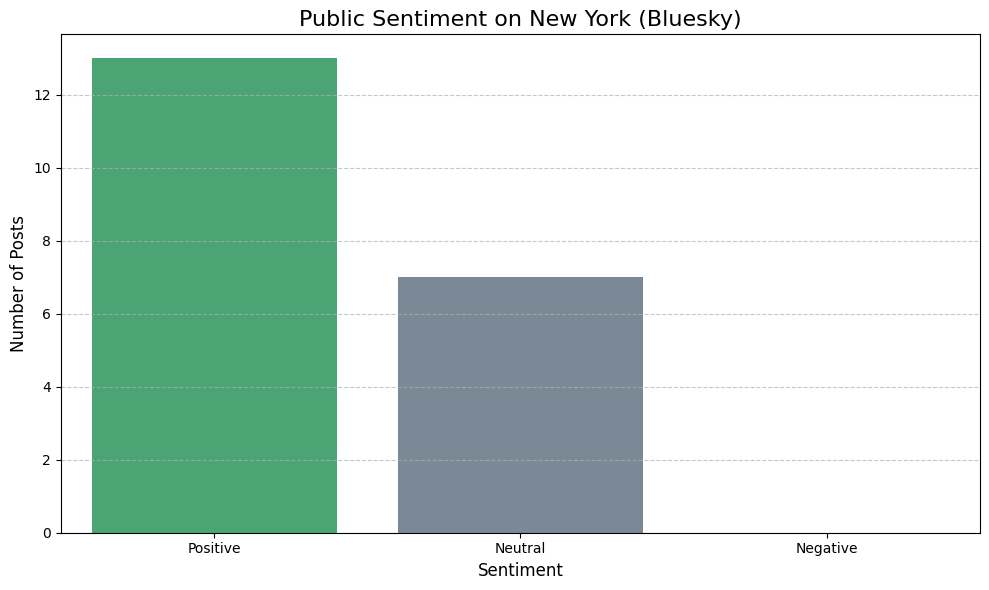

In [7]:
df_ny_sentiment = get_sentiment(ny_posts)
plot_sentiment(df_ny_sentiment, "New York", style="petroff10")

In [8]:
trump_posts = fetch_bsky_posts("Trump", limit=100)
trump_posts

,text,author,created_at
0,ohhhh!!! okay. i'm sorry - i thought you were ...,pastapope.bsky.social,2025-07-11T20:13:41.291Z
1,she looks stupid with her trump hat on.,jrm-girlie.bsky.social,2025-07-11T20:13:39.358Z
2,hey it took her three days to respond because ...,klhubbs.bsky.social,2025-07-11T20:13:38.991Z
3,"normalement je souhaite pas de mal, mais eux.....",doomgenesis.bsky.social,2025-07-11T20:13:38.719Z
4,did jerome powell really just agree to resign ...,barble.bsky.social,2025-07-11T20:13:38.651Z
...,...,...,...
95,just in: dan bongino reportedly forcing trump ...,eviebauer727.bsky.social,2025-07-11T20:12:10.339Z
96,@kyivpost: trump is considering a new military...,news-feed.bsky.social,2025-07-11T20:12:10.332Z
97,"between this and elon turning on trump, uh...",harrydamour.bsky.social,2025-07-11T20:12:08.806Z
98,"und die nato werde die kosten zu 100 % tragen,...",pumuckel-2te.bsky.social,2025-07-11T20:12:08.373Z


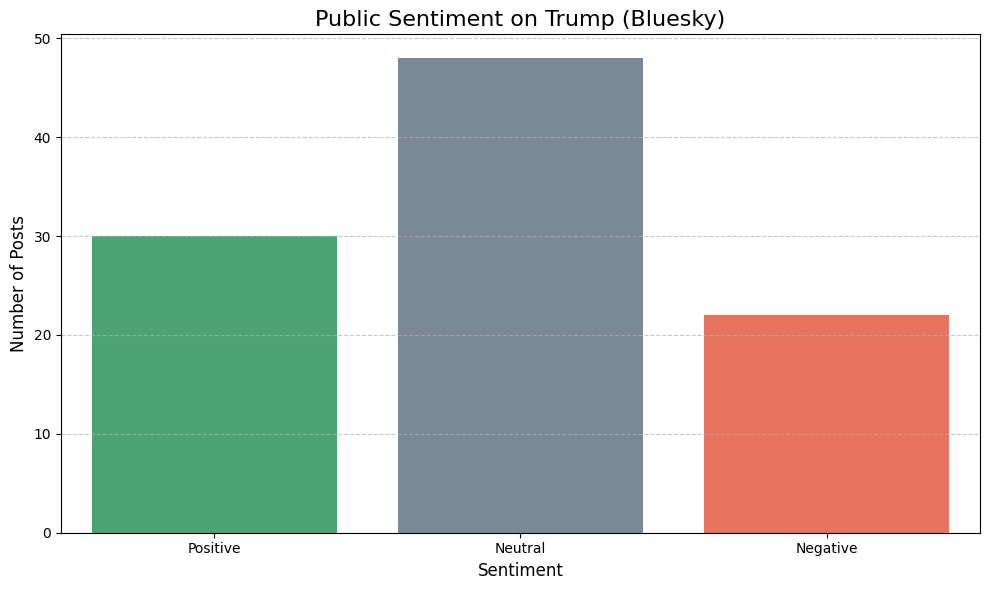

In [9]:
trump_sentiment = get_sentiment(trump_posts)
plot_sentiment(trump_sentiment, "Trump", style="petroff10")

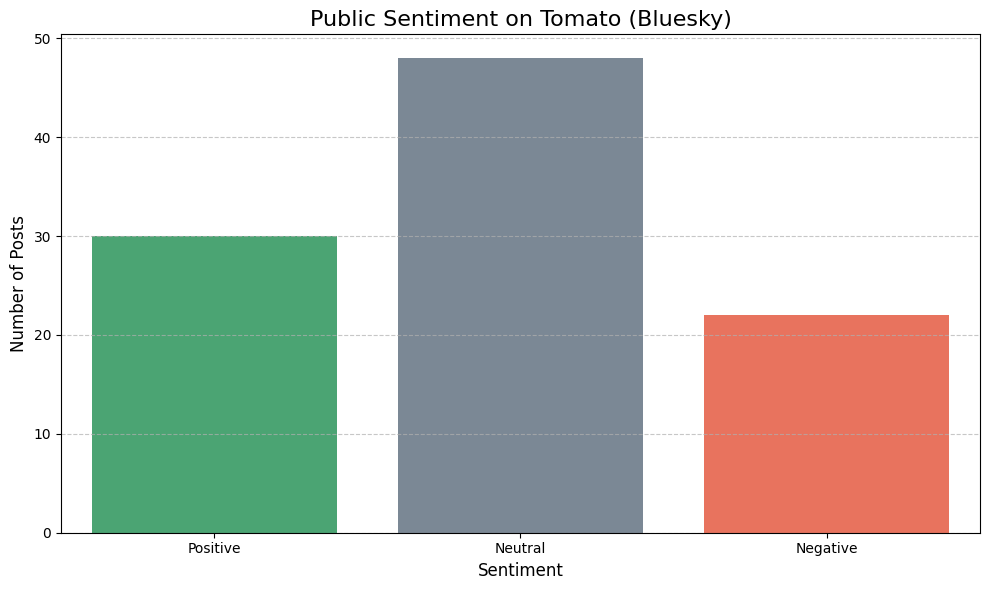

In [10]:
tomato_posts = fetch_bsky_posts("Tomato", limit=100)
tomato_sentiment = get_sentiment(tomato_posts)
plot_sentiment(trump_sentiment, "Tomato", style="petroff10")